<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/4_DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
 ! pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=ed3984aa28d8a8ed9167b89ac28e35980fdc2c778ba533c7a0cc8b72f115f531
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [ ]:
steps=5000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

# Auxiliary Functions


In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

# Problem Setup
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

**Diffusion equation**

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

### Exact solution:

$$y(x,t)=e^{-t}sin(\pi x)$$

# Analysis:
## PDE
$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If we rearrange our PDE, we get:

$$\left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx y(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx y(t,x)$$ 

Then:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx \left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

And:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx 0$$


We define this function as $f$:

$$f(t,x)=\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

#### Initial Condition:

$$y(x,0)=sin(\pi x)$$

#### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

## Functions

In [ ]:
def f_IC(x):
  return torch.sin(np.pi*x)
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))
def PDE(X): #Non differential part
  x=X[:,0].unsqueeze(1)
  t=X[:,1].unsqueeze(1)
  return -(torch.exp(-t))*(torch.sin(np.pi*x)-(np.pi**2)*torch.sin(np.pi*x))


### Neural Network

In [ ]:
class FCN(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      #f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
      #return self.loss_function(f,f_hat)
      return self.loss_function(f_t-f_xx,PDE(g))

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss   

# Generate data

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


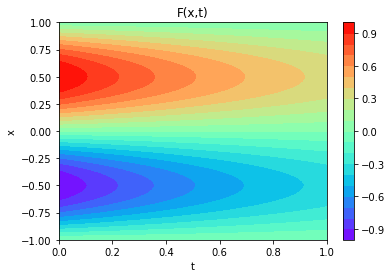

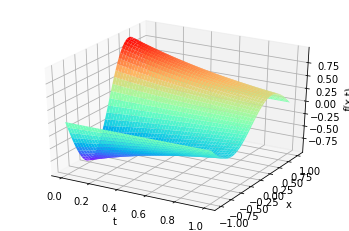

In [ ]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)

In [ ]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


## Prepare Data

In [ ]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


## Training Data

In [ ]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=y_real[0,:][:,None]
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=y_real[-1,:][:,None]
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [ ]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


# Train Neural Network

In [ ]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#optimizer.step(PINN.closure)

In [ ]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
0.0007449757 --- 0.03654573
0.00054287753 --- 0.036423203
0.00057380437 --- 0.03657827
0.0003779921 --- 0.036245283
0.00031389765 --- 0.036219735
0.000437135 --- 0.03604433
0.0002276038 --- 0.036208697
0.00019518183 --- 0.036177997
0.00017078474 --- 0.036169223
0.00016230089 --- 0.03620189


### Plots

In [ ]:
y1=PINN(X_test)

In [ ]:
x1=X_test[:,0]
t1=X_test[:,1]

In [ ]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

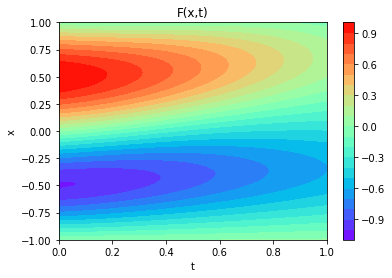

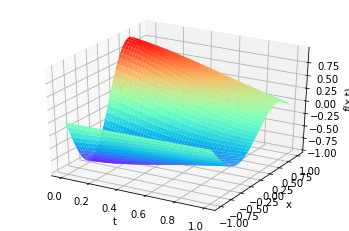

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

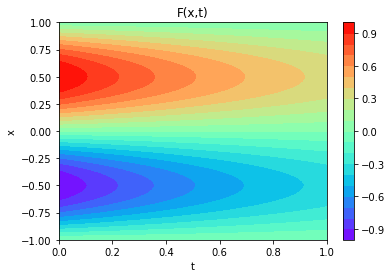

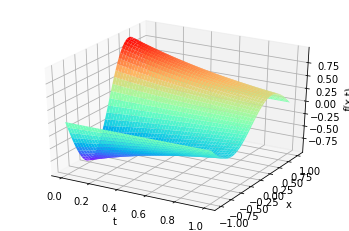

In [ ]:
plot3D_Matrix(X,T,y_real)

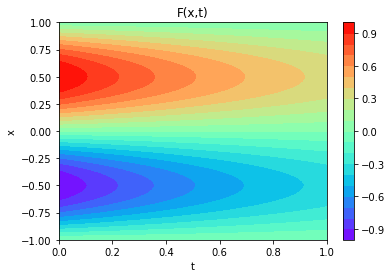

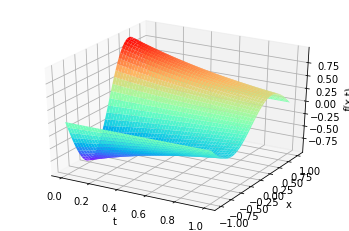

In [ ]:
plot3D_Matrix(X,T,arr_y_test)

In [ ]:
PINN.loss_function(y_real,arr_y1)

tensor(0.0361)

## References:


[1] Maziar Raissi, Paris Perdikaris, and George Em Karniadakis. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. http://arxiv.org/pdf/1711.10561v1

[2] Lu Lu et al. DeepXDE: A deep learning library for solving differential equations.2019. https://arxiv.org/abs/1907.04502
